In [1]:
#Import the necessary Python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from fbprophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

In [3]:
#Import the dataset

global_deaths = pd.read_csv("covid19-data-from-john-hopkins-university/CONVENIENT_global_deaths.csv")
#global_deaths

In [4]:
global_deaths = global_deaths[1:]
#global_deaths

In [5]:
#Select Russia's deaths data only for prediction

RUS_deaths = pd.DataFrame(global_deaths[["Country/Region","Russia"]])
#RUS_deaths.head()

In [6]:
#Change the header of Russian deaths data

RUS_deaths.columns = ['Date','Deaths']
RUS_deaths

,Date,Deaths
1,1/23/20,0.0
2,1/24/20,0.0
3,1/25/20,0.0
4,1/26/20,0.0
5,1/27/20,0.0
...,...,...
675,11/27/21,1203.0
676,11/28/21,1190.0
677,11/29/21,1178.0
678,11/30/21,1195.0


In [7]:
#Check for missing value(s) in the Russian deaths data

RUS_deaths.isnull().sum()

Date      0
Deaths    0
dtype: int64

In [8]:
RUS_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 1 to 679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    679 non-null    object 
 1   Deaths  679 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.7+ KB


In [9]:
RUS_deaths['Date']= pd.to_datetime(RUS_deaths['Date'])

In [10]:
RUS_deaths = RUS_deaths.set_index(['Date'])

In [11]:
def create_time_features(RUS_deaths):
    """
    Creates time series features from datetime index
    """
    RUS_deaths['date'] = RUS_deaths.index
    RUS_deaths['hour'] = RUS_deaths['date'].dt.hour
    RUS_deaths['dayofweek'] = RUS_deaths['date'].dt.dayofweek
    RUS_deaths['quarter'] = RUS_deaths['date'].dt.quarter
    RUS_deaths['month'] = RUS_deaths['date'].dt.month
    RUS_deaths['year'] = RUS_deaths['date'].dt.year
    RUS_deaths['dayofyear'] = RUS_deaths['date'].dt.dayofyear
    RUS_deaths['dayofmonth'] = RUS_deaths['date'].dt.day
    RUS_deaths['weekofyear'] = RUS_deaths['date'].dt.weekofyear
    
    X = RUS_deaths[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [12]:
create_time_features(RUS_deaths).head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,0,6,1,1,2020,26,26,4
2020-01-27,0,0,1,1,2020,27,27,5


In [13]:
RUS_deaths.head()

,Deaths,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,
2020-01-23,0.0,2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,0.0,2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,0.0,2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,0.0,2020-01-26,0,6,1,1,2020,26,26,4
2020-01-27,0.0,2020-01-27,0,0,1,1,2020,27,27,5


In [14]:
RUS_deaths.drop("date", axis=1, inplace=True)
RUS_deaths.drop("hour", axis=1, inplace=True)
RUS_deaths.drop("dayofweek", axis=1, inplace=True)
RUS_deaths.drop("quarter", axis=1, inplace=True)
RUS_deaths.drop("dayofyear", axis=1, inplace=True)
RUS_deaths.drop("weekofyear", axis=1, inplace=True)

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

In [16]:
RUS_deaths = FunLabelEncoder(RUS_deaths)
RUS_deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679 entries, 2020-01-23 to 2021-12-01
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Deaths      679 non-null    float64
 1   month       679 non-null    int64  
 2   year        679 non-null    int64  
 3   dayofmonth  679 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 26.5 KB


In [17]:
RUS_deaths

,Deaths,month,year,dayofmonth
Date,,,,
2020-01-23,0.0,1,2020,23
2020-01-24,0.0,1,2020,24
2020-01-25,0.0,1,2020,25
2020-01-26,0.0,1,2020,26
2020-01-27,0.0,1,2020,27
...,...,...,...,...
2021-11-27,1203.0,11,2021,27
2021-11-28,1190.0,11,2021,28
2021-11-29,1178.0,11,2021,29


In [18]:
X = RUS_deaths[['month', 'year','dayofmonth']]
Y = RUS_deaths[['Deaths']]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)

In [20]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,Y_train)

LinearRegression()

In [21]:
LR.score(X_test,Y_test)

0.8345933558413825

In [22]:
X_test.shape

(204, 3)

In [23]:
LR.predict(X_test)

array([[  82.5608885 ],
       [ 272.67154097],
       [ 639.86584097],
       [ 751.57002512],
       [ 398.69869091],
       [  73.68149762],
       [ 397.69481144],
       [ 817.41143194],
       [ -83.88546385],
       [ 479.07515231],
       [ 672.40953197],
       [ -18.79808186],
       [ -42.46238197],
       [-132.72211373],
       [ 465.75606598],
       [ 606.56812515],
       [ 368.37484764],
       [ 386.59557283],
       [ 714.58663868],
       [ 710.14694324],
       [ 585.12367276],
       [ 462.32025001],
       [  67.02195445],
       [ 455.66070685],
       [ 345.17249095],
       [ 613.22766831],
       [ 312.62879996],
       [  14.49963396],
       [ 784.86774094],
       [ 696.82785691],
       [ 317.0684954 ],
       [ 810.75188877],
       [ -24.7036002 ],
       [ -66.88070691],
       [ 644.30553642],
       [ 508.18302734],
       [ 198.70476809],
       [ 222.3690682 ],
       [ 348.39621814],
       [ -35.80283881],
       [ 872.15360015],
       [ 494.863

In [24]:
import numpy as np
from sklearn.model_selection import cross_val_score
reg_cv=LinearRegression()
cv_scores=cross_val_score(reg_cv,X,Y,cv=6)
np.mean(cv_scores)

-5.886971464924854

In [25]:
Y_pred = LR.predict(X_test)
print("Coefficients: \n", LR.coef_)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

Coefficients: 
 [[ 56.96201593 524.76126148   2.21984772]]
Coefficient of determination: 0.83


In [36]:
LR_prediction = LR.predict(X_test)
LR_prediction = pd.DataFrame(LR_prediction)
LR_prediction.columns = ["Deaths_LR.prediction"]
LR_prediction

,Deaths_LR.prediction
0,82.560889
1,272.671541
2,639.865841
3,751.570025
4,398.698691
...,...
199,174.286443
200,47.043325
201,953.533941
202,898.037748


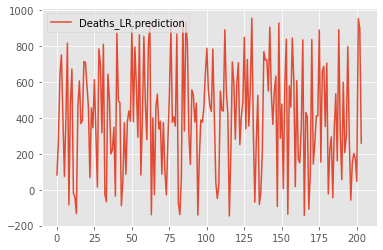

In [37]:
LR_prediction.plot()
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier

# We define the model
tree_model= RandomForestClassifier(n_estimators=100, max_depth=200,
                        random_state=1)

In [38]:
from sklearn.ensemble import RandomForestClassifier

# We define the model
tree_model= RandomForestClassifier(n_estimators=100, max_depth=200,
                        random_state=1)
tree_model.fit(X_train,Y_train)
RF_prediction = tree_model.predict(X_test)
print("Coefficient of determination: %.2f" % r2_score(Y_test, RF_prediction))

<ipython-input-38-c4fb29c18264>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_model.fit(X_train,Y_train)


Coefficient of determination: 0.98


In [40]:
RF_prediction = pd.DataFrame(RF_prediction)
RF_prediction.columns = ["Deaths_RF_prediction"]

In [41]:
RF_prediction.head()

,Deaths_RF_prediction
0,174.0
1,141.0
2,374.0
3,799.0
4,519.0


In [42]:
RF_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Deaths_RF_prediction  204 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


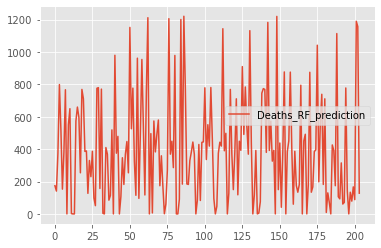

In [43]:
RF_prediction.plot()
plt.show()